# Imports and Data Loading

In [139]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import scipy.io as sio
from scipy.ndimage import gaussian_filter, binary_opening, binary_closing
from scipy.signal import find_peaks, butter, filtfilt
from skimage.filters import threshold_otsu
from skimage.measure import find_contours

In [287]:
data = sio.loadmat('./data/021925/gait_recording_021925_walk11.mat')
insoleAll_l = data['insoleAll_l'].astype(np.float64)
insoleAll_r = data['insoleAll_r'].astype(np.float64)
t_insole_l = data['t_insole_l'].astype(np.float64)
t_insole_r = data['t_insole_r'].astype(np.float64)

In [288]:
# Computing averages
avg_l = np.mean(insoleAll_l, axis=0)  # Result is 1 x 1024
avg_r = np.mean(insoleAll_r, axis=0)  # Result is 1 x 1024

# Reshape the averages into 64 x 16 images
img_avg_l = np.reshape(avg_l, (64, 16), order='F')
img_avg_r = np.reshape(avg_r, (64, 16), order='F')

# Flip right insole left-right and flip top half of both up-down
img_avg_r = np.fliplr(img_avg_r)
img_avg_l[:32, :] = np.flipud(img_avg_l[:32, :])
img_avg_r[:32, :] = np.flipud(img_avg_r[:32, :])

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


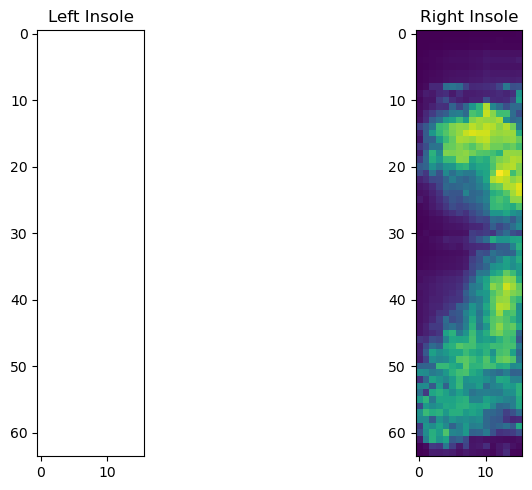

In [289]:
# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Left Insole Plot
axs[0].imshow(img_avg_l)
axs[0].set_title("Left Insole")

# Right Insole Plot
axs[1].imshow(img_avg_r)
axs[1].set_title("Right Insole")

plt.tight_layout()
plt.show()

# Creating outline of foot

In [290]:
tunable_params = {
    'insole_dims': (64, 16),
    # Gaussian filter
    'pad_width': 1,
    'sigma': 1.0,
    'morph_size': 3,
    # Fixed threshold for the mask:
    'foot_mask_threshold_l': 150,
    'foot_mask_threshold_r': 900,
    # Toggle for Gaussian smoothing:
    'apply_gaussian': True,  
    'aggregation_window': 40,
    'lowpass_cutoff': 8,
    'fs': 50,
    'filter_order': 4,
    # Heel strike and toe off thresholds
    'h_th_r': 30,
    't_th_r': 30,
    'h_th_l': 30,
    't_th_l': 30,
    'strike_th_l': 2,
    'strike_th_r': 2,
    # Animation
    'animation_interval': 50,
}

In [291]:
def extract_foot_mask(pressure_data, threshold=None, sigma=tunable_params['sigma'], 
                        morph_size=tunable_params['morph_size'], pad_width=tunable_params['pad_width']):
    """
    Extracts a binary foot mask from a pressure data array.
    If smoothing is disabled, the raw padded data is used.
    Uses a tunable threshold value (defaulting to tunable_params['foot_mask_threshold'])
    """
    padded_data = np.pad(pressure_data, pad_width=pad_width, mode='edge')
    
    # Apply Gaussian smoothing if enabled; otherwise, use the raw padded data.
    if tunable_params.get('apply_gaussian', True):
        processed_data = gaussian_filter(padded_data, sigma=sigma)
    else:
        processed_data = padded_data

    # Use the tunable threshold value if none is provided.
    if threshold is None:
        threshold = tunable_params.get('foot_mask_threshold', 0)

    binary_mask = processed_data > threshold
    structure = np.ones((morph_size, morph_size))
    cleaned_mask = binary_opening(binary_mask, structure=structure)
    cleaned_mask = binary_closing(cleaned_mask, structure=structure)
    mask = cleaned_mask[pad_width:-pad_width, pad_width:-pad_width]
    return mask

def aggregate_mask_central_window(insole_data, step, dim=tunable_params['insole_dims'], 
                                  window=tunable_params['aggregation_window'], threshold=None, 
                                  sigma=tunable_params['sigma'], morph_size=tunable_params['morph_size'], 
                                  pad_width=tunable_params['pad_width']):
    """
    Aggregates binary masks for frames in a window of +/- 'window' frames 
    around the mid-point (between strike and off).
    """
    start_idx = step['strike'][0]
    off_idx = step['off'][0] if step['off'] else (step['strike'][1] if len(step['strike']) > 1 else start_idx)
    mid_idx = (start_idx + off_idx) // 2
    window_start = max(start_idx, mid_idx - window)
    window_end = min(off_idx, mid_idx + window)
    agg_mask = np.zeros(dim, dtype=bool)
    for i in range(window_start, window_end + 1):
        frame = insole_data[i, :].reshape(dim, order='F')
        mask = extract_foot_mask(frame, threshold=threshold, sigma=sigma,
                         morph_size=morph_size, pad_width=pad_width)
        agg_mask = np.logical_or(agg_mask, mask)
    return agg_mask

def butter_lowpass_filter(data, cutoff=tunable_params['lowpass_cutoff'], fs=tunable_params['fs'], order=tunable_params['filter_order']):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def reshape_insole_grid(data, dims=tunable_params['insole_dims']):
    num_frames = data.shape[0]
    reshaped_data = np.empty((num_frames, dims[0], dims[1]), dtype=data.dtype)
    for i in range(num_frames):
        # Reshape using Fortran-order equivalent and flip the top half.
        frame = data[i].reshape(dims[1], dims[0]).T.copy()
        frame[:32, :] = np.flipud(frame[:32, :])
        reshaped_data[i] = frame
    return reshaped_data

def segment_insole_data(insole_data):
    toe_region = insole_data[:, :15, :]
    forefoot_region = insole_data[:, 15:33, :]
    midfoot_region = insole_data[:, 33:47, :]
    heel_region = insole_data[:, 47:, :]
    return heel_region, midfoot_region, forefoot_region, toe_region

def gait_segmentation(insole, h_th, t_th):
    insole = reshape_insole_grid(insole)
    heel_region, midfoot_region, forefoot_region, toe_region = segment_insole_data(insole)
    p_heel = np.mean(heel_region, axis=(1, 2))
    p_toe = np.mean(toe_region, axis=(1, 2))
    p_forefoot = np.mean(forefoot_region, axis=(1, 2))
    p_heel_filtered = butter_lowpass_filter(p_heel)
    p_fore_filtered = butter_lowpass_filter(p_toe + p_forefoot)
    p_heel_derivative = np.gradient(p_heel_filtered)
    p_fore_derivative = np.gradient(p_fore_filtered)
    hc_indices, _ = find_peaks(p_heel_derivative, height=h_th, distance=20)
    to_indices, _ = find_peaks(-p_fore_derivative, height=t_th, distance=20)
    return hc_indices, to_indices

def get_gait_event_masks(insole_r, insole_l, t_r, t_l, thresholds, dim=tunable_params['insole_dims']):
    """
    Extracts gait event timestamps (strike and off) and aggregates the foot outline mask
    for each step.
    """
    h_th_r, t_th_r, h_th_l, t_th_l, strike_th_l, strike_th_r = thresholds
    
    # --- Process Right Foot ---
    hc_indices_r, to_indices_r = gait_segmentation(insole_r, h_th_r, t_th_r)
    strike_r = hc_indices_r
    off_r = to_indices_r
    steps_r = []
    for i in range(len(strike_r) - 1):
        start, end = strike_r[i], strike_r[i + 1]
        if t_r[end] - t_r[start] > strike_th_r:
            continue
        step_off = [o for o in off_r if start <= o <= end]
        steps_r.append({'strike': [start, end], 'off': step_off})
    foot_mask_r = [aggregate_mask_central_window(insole_r, step, dim=dim, threshold=tunable_params.get('foot_mask_threshold_r'))
                   for step in steps_r]
    
    # --- Process Left Foot ---
    hc_indices_l, to_indices_l = gait_segmentation(insole_l, h_th_l, t_th_l)
    strike_l = hc_indices_l
    off_l = to_indices_l
    steps_l = []
    for i in range(len(strike_l) - 1):
        start, end = strike_l[i], strike_l[i + 1]
        if t_l[end] - t_l[start] > strike_th_l:
            continue
        step_off = [o for o in off_l if start <= o <= end]
        steps_l.append({'strike': [start, end], 'off': step_off})
    foot_mask_l = [aggregate_mask_central_window(insole_l, step, dim=dim, threshold=tunable_params.get('foot_mask_threshold_l'))
                   for step in steps_l]
    
    return {
        'steps_r': steps_r,
        'steps_l': steps_l,
        'foot_mask_r': foot_mask_r,
        'foot_mask_l': foot_mask_l,
    }

In [292]:
# Animate a single step to confirm segmentation
# Define thresholds for [h_th_r, t_th_r, h_th_l, t_th_l, strike_th_l, strike_th_r]
thresholds = [
    tunable_params['h_th_r'], tunable_params['t_th_r'], 
    tunable_params['h_th_l'], tunable_params['t_th_l'], 
    tunable_params['strike_th_l'], tunable_params['strike_th_r']
]

# Compute Gait Event Masks
gait_events = get_gait_event_masks(insoleAll_r, insoleAll_l, t_insole_r, t_insole_l, thresholds, dim=tunable_params['insole_dims'])

# For animation, select the first valid step for each foot.
selected_step_r = gait_events['steps_r'][0]
selected_step_l = gait_events['steps_l'][0]

# Extract step frames for right and left feet.
start_idx_r = selected_step_r['strike'][0]
off_idx_r = selected_step_r['off'][0] if selected_step_r['off'] else (selected_step_r['strike'][1] if len(selected_step_r['strike']) > 1 else start_idx_r)
step_frames_r = insoleAll_r[start_idx_r:off_idx_r+1, :]

start_idx_l = selected_step_l['strike'][0]
off_idx_l = selected_step_l['off'][0] if selected_step_l['off'] else (selected_step_l['strike'][1] if len(selected_step_l['strike']) > 1 else start_idx_l)
step_frames_l = insoleAll_l[start_idx_l:off_idx_l+1, :]

# --- Animation: Arrange so Left Foot is on the left and Right Foot is on the right ---
fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(12, 8))

# Left Foot Animation: only flip the top half.
init_frame_l = step_frames_l[0].reshape(tunable_params['insole_dims'], order='F')
init_frame_l[:32, :] = np.flipud(init_frame_l[:32, :])
im_l = ax_l.imshow(init_frame_l, cmap='viridis', interpolation='nearest')
ax_l.axis('off')
ax_l.set_title("Left Foot Animation\nFrame: {}".format(start_idx_l))

# Right Foot Animation: flip left-right then flip the top half.
init_frame_r = step_frames_r[0].reshape(tunable_params['insole_dims'], order='F').copy()
init_frame_r = np.fliplr(init_frame_r)
init_frame_r[:32, :] = np.flipud(init_frame_r[:32, :])
im_r = ax_r.imshow(init_frame_r, cmap='viridis', interpolation='nearest')
ax_r.axis('off')
ax_r.set_title("Right Foot Animation\nFrame: {}".format(start_idx_r))

n_frames_r = step_frames_r.shape[0]
n_frames_l = step_frames_l.shape[0]
max_frames = max(n_frames_r, n_frames_l)

def update(frame_index):
    # Update Right Foot Animation (right subplot)
    idx_r = frame_index if frame_index < n_frames_r else n_frames_r - 1
    frame_data_r = step_frames_r[idx_r].reshape(tunable_params['insole_dims'], order='F').copy()
    frame_data_r = np.fliplr(frame_data_r)
    frame_data_r[:32, :] = np.flipud(frame_data_r[:32, :])
    im_r.set_data(frame_data_r)
    ax_r.set_title(f"Right Foot Animation\nFrame: {start_idx_r + idx_r}")
    
    # Update Left Foot Animation (left subplot)
    idx_l = frame_index if frame_index < n_frames_l else n_frames_l - 1
    frame_data_l = step_frames_l[idx_l].reshape(tunable_params['insole_dims'], order='F').copy()
    frame_data_l[:32, :] = np.flipud(frame_data_l[:32, :])
    im_l.set_data(frame_data_l)
    ax_l.set_title(f"Left Foot Animation\nFrame: {start_idx_l + idx_l}")
    
    return [im_l, im_r]

anim = animation.FuncAnimation(fig, update, frames=range(max_frames), interval=tunable_params['animation_interval'], blit=False)
HTML(anim.to_jshtml())

ValueError: The length of the input vector x must be greater than padlen, which is 15.

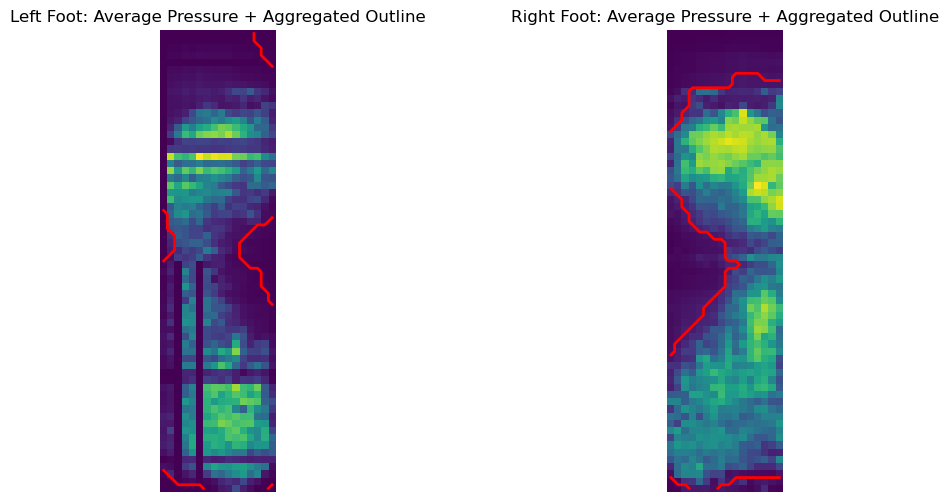

In [281]:
# Compute aggregated masks using a central window (± aggregation_window frames).
agg_mask_r = aggregate_mask_central_window(
    insoleAll_r, selected_step_r, dim=tunable_params['insole_dims'],
    window=tunable_params['aggregation_window'], threshold=tunable_params.get('foot_mask_threshold_r')
)
agg_mask_l = aggregate_mask_central_window(
    insoleAll_l, selected_step_l, dim=tunable_params['insole_dims'],
    window=tunable_params['aggregation_window'], threshold=tunable_params.get('foot_mask_threshold_l')
)
agg_mask_r = np.fliplr(agg_mask_r)
agg_mask_r[:32, :] = np.flipud(agg_mask_r[:32, :])

# Extract contours from the aggregated masks.
contours_r = find_contours(agg_mask_r, level=0.5)
contours_l = find_contours(agg_mask_l, level=0.5)

# Plot the aggregated outlines on the average pressure images.
fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(12, 6))

# Left Foot Plot (left subplot)
ax_l.imshow(img_avg_l, cmap='viridis', interpolation='nearest')
for contour in contours_l:
    ax_l.plot(contour[:, 1], contour[:, 0], 'r', linewidth=2)
ax_l.set_title("Left Foot: Average Pressure + Aggregated Outline")
ax_l.axis('off')

# Right Foot Plot (right subplot)
ax_r.imshow(img_avg_r, cmap='viridis', interpolation='nearest')
for contour in contours_r:
    ax_r.plot(contour[:, 1], contour[:, 0], 'r', linewidth=2)
ax_r.set_title("Right Foot: Average Pressure + Aggregated Outline")
ax_r.axis('off')

plt.show()

# Dividing by joints

## Drawing boundary lines

In [187]:
# Helper function to rotate graphed line
def get_angled_line_coords(y_center, angle_deg, x_min=0, x_max=15, n_points=50):

    """
    Returns arrays of (x_vals, y_vals) in "image coordinates" for a line:
      - spanning from x_min to x_max
      - passing through (x_center, y_center) at the midpoint in x
      - tilted by angle_deg. (Positive angle = 'counterclockwise' in normal math.)
        However, note that in an imshow with origin='upper', the y-axis is inverted.
    """
    angle_rad = np.deg2rad(angle_deg)

    x_vals = np.linspace(x_min, x_max, n_points)
    slope = -np.tan(angle_rad)

    x_center = (x_min + x_max) / 2.0

    # Equation of the line in image coords: y = y_center + slope*(x - x_center)
    y_vals = y_center + slope * (x_vals - x_center)

    return x_vals, y_vals

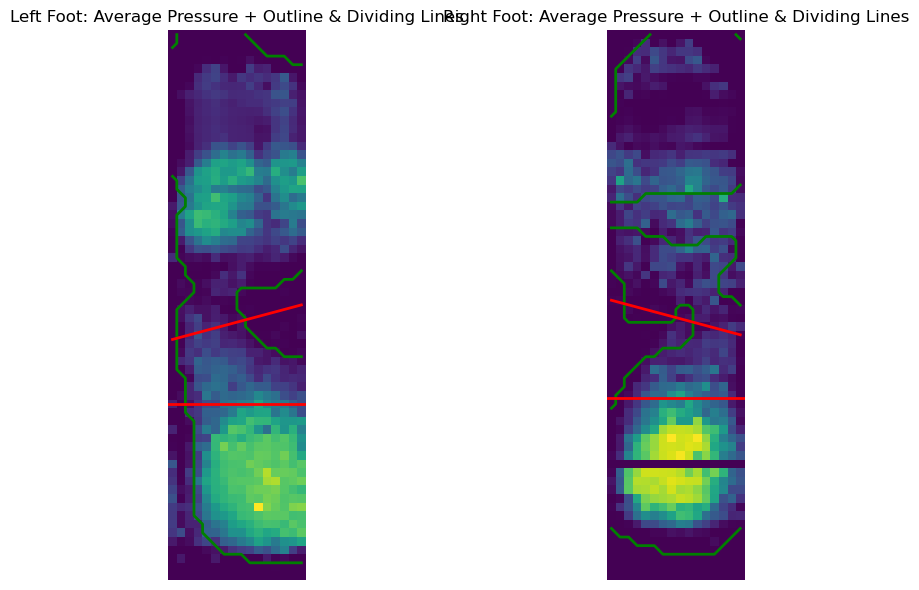

In [188]:
# Compute the extreme points of the aggregated masks from the first step
first_step_l = gait_events['steps_l'][0]
first_step_r = gait_events['steps_r'][0]

# Get the aggregated mask for the first step of each foot
agg_mask_l = aggregate_mask_central_window(
    insoleAll_l, first_step_l, 
    dim=tunable_params['insole_dims'], 
    window=tunable_params['aggregation_window'],
    threshold=tunable_params.get('foot_mask_threshold_l')
)
agg_mask_r_flipped = np.fliplr(aggregate_mask_central_window(
    insoleAll_r, first_step_r, 
    dim=tunable_params['insole_dims'], 
    window=tunable_params['aggregation_window'],
    threshold=tunable_params.get('foot_mask_threshold_r')
))

# Find the boundaries from the aggregated masks
rows_l, cols_l = np.where(agg_mask_l)
rows_r, cols_r = np.where(agg_mask_r_flipped)

# Left foot boundaries from aggregated mask
foot_top_l = rows_l.min()
foot_bot_l = rows_l.max()
foot_left_l = cols_l.min()
foot_right_l = cols_l.max()
# Right foot boundaries from aggregated mask
foot_top_r = rows_r.min()
foot_bot_r = rows_r.max()
foot_left_r = cols_r.min()
foot_right_r = cols_r.max()

# Compute vertical foot lengths for proportional lines
foot_length_l = foot_bot_l - foot_top_l + 1
foot_length_r = foot_bot_r - foot_top_r + 1

# Define dividing lines
line1_l = foot_top_l + 0.54 * foot_length_l  # 54% from the top for the left foot
line2_l = foot_bot_l - 0.29 * foot_length_l  # 29% from the bottom for the left foot
line1_r = foot_top_r + 0.54 * foot_length_r  # 54% from the top for the right foot
line2_r = foot_bot_r - 0.29 * foot_length_r  # 29% from the bottom for the right foot

# Extract the contours from the aggregated masks
contours_l = find_contours(agg_mask_l, level=0.5)
contours_r = find_contours(agg_mask_r_flipped, level=0.5)  # Use the flipped mask for contours

# Plot the average pressure images with the aggregated outline and dividing lines
fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(12, 6))

# Left Foot Plot - using average pressure
ax_l.imshow(img_avg_l, cmap='viridis', interpolation='nearest')
# Plot the aggregated foot outline in green:
for contour in contours_l:
    ax_l.plot(contour[:, 1], contour[:, 0], 'g', linewidth=2)
# Draw dividing lines on the left foot:
angle_left = 15  # positive angle for left foot
xl1, yl1 = get_angled_line_coords(line1_l, angle_left,
                                  x_min=foot_left_l, x_max=foot_right_l, n_points=50)
ax_l.plot(xl1, yl1, color='r', linewidth=2)  # angled line
ax_l.axhline(line2_l, color='r', linewidth=2)  # horizontal line
ax_l.set_title("Left Foot: Average Pressure + Outline & Dividing Lines")
ax_l.axis('off')

# Right Foot Plot - using average pressure
ax_r.imshow(img_avg_r, cmap='viridis', interpolation='nearest')
# Plot the aggregated foot outline in green:
for contour in contours_r:
    ax_r.plot(contour[:, 1], contour[:, 0], 'g', linewidth=2)
# Draw dividing lines on the right foot:
angle_right = -15  # negative angle for right foot
xr1, yr1 = get_angled_line_coords(line1_r, angle_right,
                                 x_min=foot_left_r, x_max=foot_right_r, n_points=50)
ax_r.plot(xr1, yr1, color='r', linewidth=2)  # angled line
ax_r.axhline(line2_r, color='r', linewidth=2)  # horizontal line
ax_r.set_title("Right Foot: Average Pressure + Outline & Dividing Lines")
ax_r.axis('off')

plt.tight_layout()
plt.show()

## Assigning datapoints based on boundaries

In [189]:
# Assign datapoints based on division above
forefoot_left_data  = []
midfoot_left_data   = []
hindfoot_left_data  = []

forefoot_right_data = []
midfoot_right_data  = []
hindfoot_right_data = []

# Precompute slopes from the specified angles.
slope_left  = -np.tan(np.deg2rad(angle_left))
slope_right = -np.tan(np.deg2rad(angle_right))
x_center = 7.5  # center in the x-direction (columns)

# --- Process Left Foot: Loop over each detected step ---
for step in gait_events['steps_l']:
    # Determine the frame indices for this left foot step.
    start_idx = step['strike'][0]
    if step['off']:
        off_idx = step['off'][0]
    else:
        off_idx = step['strike'][1]
        
    # Compute the aggregated mask for this step.
    agg_mask = aggregate_mask_central_window(insoleAll_l, step, 
                                             dim=tunable_params['insole_dims'], 
                                             window=tunable_params['aggregation_window'])
    # Determine boundaries of the foot (from the aggregated mask).
    rows, cols = np.where(agg_mask)
    if len(rows) == 0:
        continue  # Skip this step if the mask is empty.
    foot_top   = rows.min()
    foot_bot   = rows.max()
    foot_left  = cols.min()
    foot_right = cols.max()
    foot_length = foot_bot - foot_top + 1

    # Compute the dividing lines based on the foot outline.
    # line1 is 54% down from the top edge; line2 is 29% up from the bottom edge.
    line1 = foot_top + 0.54 * foot_length
    line2 = foot_bot - 0.29 * foot_length

    # Loop over each frame for this step.
    for i in range(start_idx, off_idx + 1):
        time_i = t_insole_l[i]
        # Reshape and flip the frame as done before.
        frame = np.reshape(insoleAll_l[i, :], (64, 16), order='F')
        frame[:32, :] = np.flipud(frame[:32, :])
        
        # Classify each pixel that is inside the aggregated foot mask.
        for col in range(16):
            # For the left foot, compute the angled boundary at this column.
            boundary1_col = line1 + slope_left * (col - x_center)
            for row in range(64):
                # Only consider pixels within the foot outline.
                if not agg_mask[row, col]:
                    continue
                val = frame[row, col]
                # Use the dividing lines to assign the pixel.
                if row < boundary1_col:
                    forefoot_left_data.append([time_i, row, col, val])
                elif row < line2:
                    midfoot_left_data.append([time_i, row, col, val])
                else:
                    hindfoot_left_data.append([time_i, row, col, val])

# --- Process Right Foot: Loop over each detected step ---
for step in gait_events['steps_r']:
    start_idx = step['strike'][0]
    if step['off']:
        off_idx = step['off'][0]
    else:
        off_idx = step['strike'][1]
        
    # Compute the aggregated mask for this right foot step.
    agg_mask = aggregate_mask_central_window(insoleAll_r, step, 
                                             dim=tunable_params['insole_dims'], 
                                             window=tunable_params['aggregation_window'])
    rows, cols = np.where(agg_mask)
    if len(rows) == 0:
        continue
    foot_top   = rows.min()
    foot_bot   = rows.max()
    foot_left  = cols.min()
    foot_right = cols.max()
    foot_length = foot_bot - foot_top + 1
    
    line1 = foot_top + 0.54 * foot_length
    line2 = foot_bot - 0.29 * foot_length

    for i in range(start_idx, off_idx + 1):
        time_i = t_insole_r[i]
        # Reshape the frame and perform the necessary flips for right foot.
        frame = np.reshape(insoleAll_r[i, :], (64, 16), order='F')
        frame = np.fliplr(frame)
        frame[:32, :] = np.flipud(frame[:32, :])
        
        for col in range(16):
            boundary1_col = line1 + slope_right * (col - x_center)
            for row in range(64):
                if not agg_mask[row, col]:
                    continue
                val = frame[row, col]
                if row < boundary1_col:
                    forefoot_right_data.append([time_i, row, col, val])
                elif row < line2:
                    midfoot_right_data.append([time_i, row, col, val])
                else:
                    hindfoot_right_data.append([time_i, row, col, val])


In [190]:
columns = ['timestamp', 'row', 'col', 'pressure']

forefoot_left_df  = pd.DataFrame(forefoot_left_data,  columns=columns)
midfoot_left_df   = pd.DataFrame(midfoot_left_data,   columns=columns)
hindfoot_left_df  = pd.DataFrame(hindfoot_left_data,  columns=columns)

forefoot_right_df = pd.DataFrame(forefoot_right_data, columns=columns)
midfoot_right_df  = pd.DataFrame(midfoot_right_data,  columns=columns)
hindfoot_right_df = pd.DataFrame(hindfoot_right_data, columns=columns)

# Ensure the timestamps are of the proper type.
forefoot_left_df['timestamp']  = forefoot_left_df['timestamp'].astype(np.float64)
midfoot_left_df['timestamp']   = midfoot_left_df['timestamp'].astype(np.float64)
hindfoot_left_df['timestamp']  = hindfoot_left_df['timestamp'].astype(np.float64)
forefoot_right_df['timestamp'] = forefoot_right_df['timestamp'].astype(np.float64)
midfoot_right_df['timestamp']  = midfoot_right_df['timestamp'].astype(np.float64)
hindfoot_right_df['timestamp'] = hindfoot_right_df['timestamp'].astype(np.float64)

# Save the DataFrames to CSV files.
forefoot_left_df.to_csv("data_by_section/GAIT080624-01/walk_4/joint/forefoot_left.csv",  index=False)
midfoot_left_df.to_csv("data_by_section/GAIT080624-01/walk_4/joint/midfoot_left.csv",    index=False)
hindfoot_left_df.to_csv("data_by_section/GAIT080624-01/walk_4/joint/hindfoot_left.csv",  index=False)

forefoot_right_df.to_csv("data_by_section/GAIT080624-01/walk_4/joint/forefoot_right.csv", index=False)
midfoot_right_df.to_csv("data_by_section/GAIT080624-01/walk_4/joint/midfoot_right.csv",   index=False)
hindfoot_right_df.to_csv("data_by_section/GAIT080624-01/walk_4/joint/hindfoot_right.csv", index=False)

In [ ]:
def build_first_step_color_image(csv_fore, csv_mid, csv_hind, region_colors, step_time_range, is_right_foot=False):
    """
    Reads three CSV files (forefoot, midfoot, hindfoot) for a single foot,
    filters for data only from the specified step_time_range, and returns 
    a color-coded image that varies brightness by pressure.
    
    For the right foot, we flip columns (c -> 15 - c) to match the left foot's display orientation.
    """
    # Load each CSV
    df_fore = pd.read_csv(csv_fore)
    df_mid  = pd.read_csv(csv_mid)
    df_hind = pd.read_csv(csv_hind)
    
    # Filter by time range for this single step
    start_time, end_time = float(step_time_range[0]), float(step_time_range[1])
    df_fore = df_fore[(df_fore['timestamp'] >= start_time) & (df_fore['timestamp'] <= end_time)]
    df_mid  = df_mid[(df_mid['timestamp'] >= start_time) & (df_mid['timestamp'] <= end_time)]
    df_hind = df_hind[(df_hind['timestamp'] >= start_time) & (df_hind['timestamp'] <= end_time)]
    
    # Concatenate all rows to find a global max pressure (so we can normalize brightness)
    all_pressures = pd.concat([df_fore['pressure'], df_mid['pressure'], df_hind['pressure']])
    if all_pressures.empty:
        max_pressure = 1.0  # fallback to 1 if there's no data
    else:
        max_pressure = all_pressures.max()
    
    # Group each region by (row, col) => mean pressure
    group_fore = df_fore.groupby(['row', 'col'])['pressure'].mean().reset_index()
    group_mid  = df_mid.groupby(['row', 'col'])['pressure'].mean().reset_index()
    group_hind = df_hind.groupby(['row', 'col'])['pressure'].mean().reset_index()
    
    # Build an empty color image (64 x 16 x 3)
    foot_img = np.zeros((64, 16, 3), dtype=float)

    # Helper to fill in region with scaled brightness
    def fill_region(df_group, base_color):
        for _, row_data in df_group.iterrows():
            r = int(row_data['row'])
            c = int(row_data['col'])
            pressure_val = row_data['pressure']
            # Normalize pressure => scale factor in [0..1]
            brightness = pressure_val / max_pressure if max_pressure > 0 else 0.0
            
            # Flip columns if this is the right foot
            if is_right_foot:
                c = 15 - c

            # Multiply the base color by the brightness
            foot_img[r, c, :] = base_color * brightness

    # Fill each region with scaled brightness
    fill_region(group_fore, region_colors['forefoot'])
    fill_region(group_mid,  region_colors['midfoot'])
    fill_region(group_hind, region_colors['hindfoot'])
    
    return foot_img

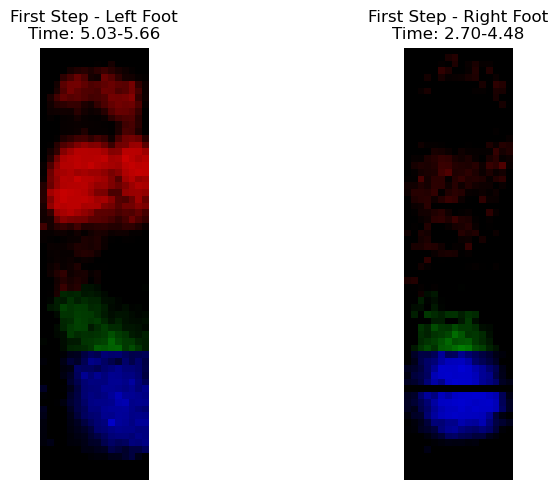

In [192]:
first_step_l = gait_events['steps_l'][0]
first_step_r = gait_events['steps_r'][0]

left_start_idx = first_step_l['strike'][0]
left_end_idx   = first_step_l['off'][0] if first_step_l['off'] else first_step_l['strike'][1]
left_start_time = float(t_insole_l[left_start_idx][0])
left_end_time   = float(t_insole_l[left_end_idx][0])
left_time_range = (left_start_time, left_end_time)

right_start_idx = first_step_r['strike'][0]
right_end_idx   = first_step_r['off'][0] if first_step_r['off'] else first_step_r['strike'][1]
right_start_time = float(t_insole_r[right_start_idx][0])
right_end_time   = float(t_insole_r[right_end_idx][0])
right_time_range = (right_start_time, right_end_time)

# --- Define the same Red/Green/Blue mapping for forefoot, midfoot, hindfoot ---
region_colors = {
    'forefoot': np.array([1.0, 0.0, 0.0]),  # Red
    'midfoot':  np.array([0.0, 1.0, 0.0]),  # Green
    'hindfoot': np.array([0.0, 0.0, 1.0])   # Blue
}

# Build the color-coded images (with pressure-based brightness) for the first step of each foot
foot_left_img = build_first_step_color_image(
    'data_by_section/GAIT080624-01/walk_4/joint/forefoot_left.csv',
    'data_by_section/GAIT080624-01/walk_4/joint/midfoot_left.csv',
    'data_by_section/GAIT080624-01/walk_4/joint/hindfoot_left.csv',
    region_colors,
    left_time_range,
    is_right_foot=False
)

foot_right_img = build_first_step_color_image(
    'data_by_section/GAIT080624-01/walk_4/joint/forefoot_right.csv',
    'data_by_section/GAIT080624-01/walk_4/joint/midfoot_right.csv',
    'data_by_section/GAIT080624-01/walk_4/joint/hindfoot_right.csv',
    region_colors,
    right_time_range,
    is_right_foot=True
)

# --- Plot side by side ---
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(foot_left_img, origin='upper')
plt.title(f"First Step - Left Foot\nTime: {left_time_range[0]:.2f}-{left_time_range[1]:.2f}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(foot_right_img, origin='upper')
plt.title(f"First Step - Right Foot\nTime: {right_time_range[0]:.2f}-{right_time_range[1]:.2f}")
plt.axis('off')

plt.tight_layout()
plt.show()

# Dividing into 6 regions (joints + center line)

In [282]:
# Helper function to rotate graphed line
def get_angled_line_coords(y_center, angle_deg, x_min=0, x_max=15, n_points=50):
    """
    Returns arrays of (x_vals, y_vals) in "image coordinates" for a line:
      - spanning from x_min to x_max
      - passing through (x_center, y_center) at the midpoint in x
      - tilted by angle_deg. (Positive angle = 'counterclockwise' in normal math.)
        However, note that in an imshow with origin='upper', the y-axis is inverted.
    """
    angle_rad = np.deg2rad(angle_deg)
    x_vals = np.linspace(x_min, x_max, n_points)
    slope = -np.tan(angle_rad)
    x_center = (x_min + x_max) / 2.0
    # Equation of the line in image coords: y = y_center + slope*(x - x_center)
    y_vals = y_center + slope * (x_vals - x_center)
    return x_vals, y_vals

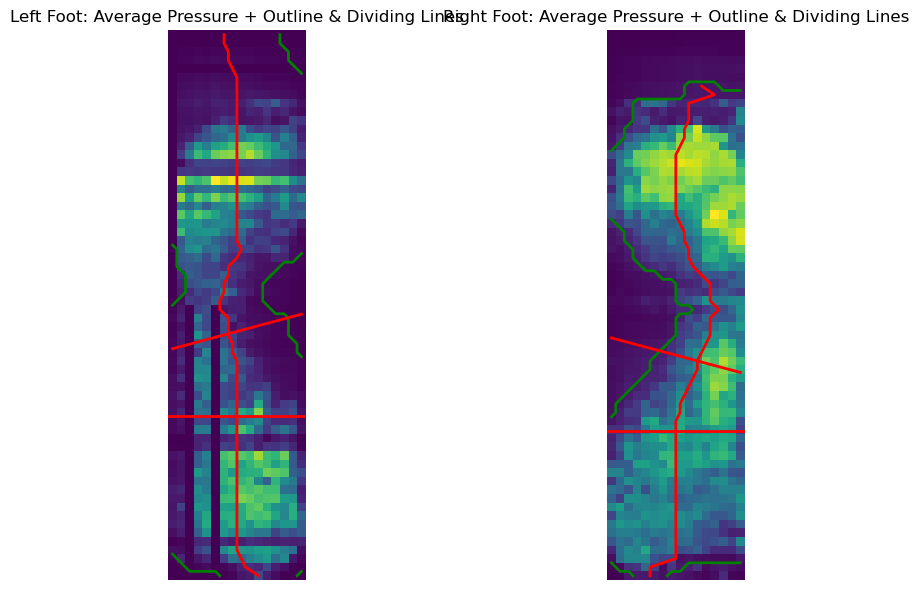

In [ ]:
# Compute the extreme points of the aggregated masks from the first step
first_step_l = gait_events['steps_l'][0]
first_step_r = gait_events['steps_r'][0]

# Get the aggregated mask for the first step of each foot
agg_mask_l = aggregate_mask_central_window(
    insoleAll_l, first_step_l, 
    dim=tunable_params['insole_dims'], 
    window=tunable_params['aggregation_window'],
    threshold=tunable_params.get('foot_mask_threshold_l')
)
agg_mask_r = aggregate_mask_central_window(
    insoleAll_r, first_step_r, 
    dim=tunable_params['insole_dims'], 
    window=tunable_params['aggregation_window'],
    threshold=tunable_params.get('foot_mask_threshold_r')
)

# Apply the same flips to the right foot mask as in the first snippet:
# First, horizontal flip; then, vertical flip on the top half.
agg_mask_r_flipped = np.fliplr(agg_mask_r)
agg_mask_r_flipped[:32, :] = np.flipud(agg_mask_r_flipped[:32, :])

# Find the boundaries from the aggregated masks
rows_l, cols_l = np.where(agg_mask_l)
rows_r, cols_r = np.where(agg_mask_r_flipped)

# Left foot boundaries from aggregated mask
foot_top_l = rows_l.min()
foot_bot_l = rows_l.max()
foot_left_l = cols_l.min()
foot_right_l = cols_l.max()
# Right foot boundaries from aggregated mask
foot_top_r = rows_r.min()
foot_bot_r = rows_r.max()
foot_left_r = cols_r.min()
foot_right_r = cols_r.max()

# Compute vertical foot lengths for proportional lines
foot_length_l = foot_bot_l - foot_top_l + 1
foot_length_r = foot_bot_r - foot_top_r + 1

# Define dividing lines (vertical separation for fore/mid/hind)
line1_l = foot_top_l + 0.54 * foot_length_l  # 54% from the top for the left foot
line2_l = foot_bot_l - 0.29 * foot_length_l   # 29% from the bottom for the left foot
line1_r = foot_top_r + 0.54 * foot_length_r    # 54% from the top for the right foot
line2_r = foot_bot_r - 0.29 * foot_length_r     # 29% from the bottom for the right foot

# Instead of using a constant mid-column, compute a row‐specific medial–lateral dividing line 
x_mid_line_l = []
y_mid_line_l = []
for row in range(foot_top_l, foot_bot_l + 1):
    cols_in_row = np.where(agg_mask_l[row, :])[0]
    if cols_in_row.size > 0:
        mid_x = (cols_in_row.min() + cols_in_row.max()) / 2.0
        x_mid_line_l.append(mid_x)
        y_mid_line_l.append(row)

x_mid_line_r = []
y_mid_line_r = []
for row in range(foot_top_r, foot_bot_r + 1):
    cols_in_row = np.where(agg_mask_r_flipped[row, :])[0]
    if cols_in_row.size > 0:
        mid_x = (cols_in_row.min() + cols_in_row.max()) / 2.0
        x_mid_line_r.append(mid_x)
        y_mid_line_r.append(row)

# Extract the contours from the aggregated masks
contours_l = find_contours(agg_mask_l, level=0.5)
contours_r = find_contours(agg_mask_r_flipped, level=0.5)  # Use the flipped mask for contours

# Plot the average pressure images with the aggregated outline and dividing lines
fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(12, 6))

# Left Foot Plot - using average pressure
ax_l.imshow(img_avg_l, cmap='viridis', interpolation='nearest')
for contour in contours_l:
    ax_l.plot(contour[:, 1], contour[:, 0], 'g', linewidth=2)
# Draw dividing lines on the left foot:
angle_left = 15  # positive angle for left foot
xl1, yl1 = get_angled_line_coords(line1_l, angle_left,
                                  x_min=foot_left_l, x_max=foot_right_l, n_points=50)
ax_l.plot(xl1, yl1, color='r', linewidth=2)  # angled line
ax_l.axhline(line2_l, color='r', linewidth=2)  # horizontal line
# Draw the computed medial–lateral dividing line (mask-based) for the left foot.
ax_l.plot(x_mid_line_l, y_mid_line_l, color='r', linewidth=2)
ax_l.set_title("Left Foot: Average Pressure + Outline & Dividing Lines")
ax_l.axis('off')

# Right Foot Plot - using average pressure
ax_r.imshow(img_avg_r, cmap='viridis', interpolation='nearest')
for contour in contours_r:
    ax_r.plot(contour[:, 1], contour[:, 0], 'g', linewidth=2)
angle_right = -15  # negative angle for right foot
xr1, yr1 = get_angled_line_coords(line1_r, angle_right,
                                  x_min=foot_left_r, x_max=foot_right_r, n_points=50)
ax_r.plot(xr1, yr1, color='r', linewidth=2)  # angled line
ax_r.axhline(line2_r, color='r', linewidth=2)  # horizontal line
# Draw the computed medial–lateral dividing line (mask-based) for the right foot.
ax_r.plot(x_mid_line_r, y_mid_line_r, color='r', linewidth=2)
ax_r.set_title("Right Foot: Average Pressure + Outline & Dividing Lines")
ax_r.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Initialize new lists for six regions for the left foot.
forelat_left_data  = []
foremed_left_data  = []
midlat_left_data   = []
midmed_left_data   = []
hindlat_left_data  = []
hindmed_left_data  = []

# Precompute slopes from the specified angles.
slope_left  = -np.tan(np.deg2rad(angle_left))
slope_right = -np.tan(np.deg2rad(angle_right))
x_center = 7.5  # center in the x-direction (columns)

# --- Process Left Foot: Loop over each detected step ---
for step in gait_events['steps_l']:
    # Determine the frame indices for this left foot step.
    start_idx = step['strike'][0]
    if step['off']:
        off_idx = step['off'][0]
    else:
        off_idx = step['strike'][1]
        
    # Compute the aggregated mask for this step.
    agg_mask = aggregate_mask_central_window(insoleAll_l, step, 
                                             dim=tunable_params['insole_dims'], 
                                             window=tunable_params['aggregation_window'],
                                             threshold=tunable_params.get('foot_mask_threshold_l'))
    # Determine boundaries of the foot (from the aggregated mask).
    rows, cols = np.where(agg_mask)
    if len(rows) == 0:
        continue  # Skip this step if the mask is empty.
    foot_top   = rows.min()
    foot_bot   = rows.max()
    foot_left  = cols.min()
    foot_right = cols.max()
    foot_length = foot_bot - foot_top + 1

    # Compute the dividing lines based on the foot outline.
    # line1 is 54% down from the top edge; line2 is 29% up from the bottom edge.
    line1 = foot_top + 0.54 * foot_length
    line2 = foot_bot - 0.29 * foot_length

    # Compute row-specific medial–lateral midline for this step.
    midline_dict = {}
    for row in range(foot_top, foot_bot + 1):
        cols_in_row = np.where(agg_mask[row, :])[0]
        if cols_in_row.size > 0:
            midline_dict[row] = (cols_in_row.min() + cols_in_row.max()) / 2.0

    # Loop over each frame for this step.
    for i in range(start_idx, off_idx + 1):
        time_i = t_insole_l[i]
        # Reshape and flip the frame as done before.
        frame = np.reshape(insoleAll_l[i, :], (64, 16), order='F')
        frame[:32, :] = np.flipud(frame[:32, :])
        
        # Classify each pixel that is inside the aggregated foot mask.
        for col in range(16):
            # For the left foot, compute the angled boundary at this column.
            boundary1_col = line1 + slope_left * (col - x_center)
            for row in range(64):
                if not agg_mask[row, col]:
                    continue
                val = frame[row, col]
                # Use row-specific midline if available, else fallback to constant mid
                current_mid = midline_dict.get(row, (foot_left + foot_right) / 2)
                if row < boundary1_col:
                    # Forefoot region
                    if col < current_mid:
                        forelat_left_data.append([time_i, row, col, val])
                    else:
                        foremed_left_data.append([time_i, row, col, val])
                elif row < line2:
                    # Midfoot region
                    if col < current_mid:
                        midlat_left_data.append([time_i, row, col, val])
                    else:
                        midmed_left_data.append([time_i, row, col, val])
                else:
                    # Hindfoot region
                    if col < current_mid:
                        hindlat_left_data.append([time_i, row, col, val])
                    else:
                        hindmed_left_data.append([time_i, row, col, val])

# Initialize new lists for six regions for the right foot.
forelat_right_data = []
foremed_right_data = []
midlat_right_data  = []
midmed_right_data  = []
hindlat_right_data = []
hindmed_right_data = []

# --- Process Right Foot: Loop over each detected step ---
for step in gait_events['steps_r']:
    start_idx = step['strike'][0]
    if step['off']:
        off_idx = step['off'][0]
    else:
        off_idx = step['strike'][1]
        
    # Compute the aggregated mask for this right foot step.
    agg_mask = aggregate_mask_central_window(insoleAll_r, step, 
                                             dim=tunable_params['insole_dims'], 
                                             window=tunable_params['aggregation_window'],
                                             threshold=tunable_params.get('foot_mask_threshold_r'))
    # Flip the aggregated mask for right foot to match display orientation.
    agg_mask = np.fliplr(agg_mask)
    rows, cols = np.where(agg_mask)
    if len(rows) == 0:
        continue
    foot_top   = rows.min()
    foot_bot   = rows.max()
    foot_left  = cols.min()
    foot_right = cols.max()
    foot_length = foot_bot - foot_top + 1
    
    line1 = foot_top + 0.54 * foot_length
    line2 = foot_bot - 0.29 * foot_length

    # Compute row-specific medial–lateral midline for this step.
    midline_dict = {}
    for row in range(foot_top, foot_bot + 1):
        cols_in_row = np.where(agg_mask[row, :])[0]
        if cols_in_row.size > 0:
            midline_dict[row] = (cols_in_row.min() + cols_in_row.max()) / 2.0

    for i in range(start_idx, off_idx + 1):
        time_i = t_insole_r[i]
        # Reshape the frame and perform the necessary flips for right foot.
        frame = np.reshape(insoleAll_r[i, :], (64, 16), order='F')
        frame = np.fliplr(frame)
        frame[:32, :] = np.flipud(frame[:32, :])
        
        for col in range(16):
            boundary1_col = line1 + slope_right * (col - x_center)
            for row in range(64):
                if not agg_mask[row, col]:
                    continue
                val = frame[row, col]
                # **EDIT**: Use row-specific midline if available, else fallback to constant mid
                current_mid = midline_dict.get(row, (foot_left + foot_right) / 2)
                if row < boundary1_col:
                    # Forefoot region
                    # For right foot, lateral is the right side (col >= current_mid)
                    if col >= current_mid:
                        forelat_right_data.append([time_i, row, col, val])
                    else:
                        foremed_right_data.append([time_i, row, col, val])
                elif row < line2:
                    # Midfoot region
                    if col >= current_mid:
                        midlat_right_data.append([time_i, row, col, val])
                    else:
                        midmed_right_data.append([time_i, row, col, val])
                else:
                    # Hindfoot region
                    if col >= current_mid:
                        hindlat_right_data.append([time_i, row, col, val])
                    else:
                        hindmed_right_data.append([time_i, row, col, val])

# Create DataFrames and save CSV files for the six regions per foot.
columns = ['timestamp', 'row', 'col', 'pressure']

# Left Foot CSVs
forelat_left_df  = pd.DataFrame(forelat_left_data,  columns=columns)
foremed_left_df  = pd.DataFrame(foremed_left_data,  columns=columns)
midlat_left_df   = pd.DataFrame(midlat_left_data,   columns=columns)
midmed_left_df   = pd.DataFrame(midmed_left_data,   columns=columns)
hindlat_left_df  = pd.DataFrame(hindlat_left_data,  columns=columns)
hindmed_left_df  = pd.DataFrame(hindmed_left_data,  columns=columns)

# Right Foot CSVs
forelat_right_df = pd.DataFrame(forelat_right_data, columns=columns)
foremed_right_df = pd.DataFrame(foremed_right_data, columns=columns)
midlat_right_df  = pd.DataFrame(midlat_right_data,  columns=columns)
midmed_right_df  = pd.DataFrame(midmed_right_data,  columns=columns)
hindlat_right_df = pd.DataFrame(hindlat_right_data, columns=columns)
hindmed_right_df = pd.DataFrame(hindmed_right_data, columns=columns)

# Ensure the timestamps are of the proper type.
for df in [forelat_left_df, foremed_left_df, midlat_left_df, midmed_left_df, hindlat_left_df, hindmed_left_df,
           forelat_right_df, foremed_right_df, midlat_right_df, midmed_right_df, hindlat_right_df, hindmed_right_df]:
    df['timestamp'] = df['timestamp'].astype(np.float64)

# Save the DataFrames to CSV files with the new filepaths.

forelat_left_df.to_csv("data_by_section/021925/walk_11/six/forelat_left.csv",  index=False)
foremed_left_df.to_csv("data_by_section/021925/walk_11/six/foremed_left.csv",  index=False)
midlat_left_df.to_csv("data_by_section/021925/walk_11/six/midlat_left.csv",    index=False)
midmed_left_df.to_csv("data_by_section/021925/walk_11/six/midmed_left.csv",    index=False)
hindlat_left_df.to_csv("data_by_section/021925/walk_11/six/hindlat_left.csv",  index=False)
hindmed_left_df.to_csv("data_by_section/021925/walk_11/six/hindmed_left.csv",  index=False)

forelat_right_df.to_csv("data_by_section/021925/walk_11/six/forelat_right.csv", index=False)
foremed_right_df.to_csv("data_by_section/021925/walk_11/six/foremed_right.csv", index=False)
midlat_right_df.to_csv("data_by_section/021925/walk_11/six/midlat_right.csv",   index=False)
midmed_right_df.to_csv("data_by_section/021925/walk_11/six/midmed_right.csv",   index=False)
hindlat_right_df.to_csv("data_by_section/021925/walk_11/six/hindlat_right.csv", index=False)
hindmed_right_df.to_csv("data_by_section/021925/walk_11/six/hindmed_right.csv", index=False)


In [ ]:
# Update region_colors mapping with six totally different colors.
region_colors = {
    'forelat': np.array([0.0, 0.0, 1.0]),    # Blue
    'foremed': np.array([1.0, 0.5, 0.0]),      # Orange
    'midlat':  np.array([0.0, 1.0, 0.0]),      # Green
    'midmed':  np.array([1.0, 0.0, 0.0]),      # Red
    'hindlat': np.array([0.5, 0.0, 0.5]),      # Purple
    'hindmed': np.array([1.0, 1.0, 0.0])       # Yellow
}

# Modified function signature to load six CSVs.
def build_first_step_color_image(csv_forelat, csv_foremed, csv_midlat, csv_midmed, csv_hindlat, csv_hindmed, region_colors, step_time_range, is_right_foot=False):
    """
    Reads six CSV files (forelat, foremed, midlat, midmed, hindlat, hindmed) for a single foot,
    filters for data only from the specified step_time_range, and returns 
    a color-coded image that varies brightness by pressure.
    
    For the right foot, we flip columns (c -> 15 - c) to match the left foot's display orientation.
    """
    # 1) Load each CSV
    df_forelat = pd.read_csv(csv_forelat)
    df_foremed = pd.read_csv(csv_foremed)
    df_midlat  = pd.read_csv(csv_midlat)
    df_midmed  = pd.read_csv(csv_midmed)
    df_hindlat = pd.read_csv(csv_hindlat)
    df_hindmed = pd.read_csv(csv_hindmed)
    
    # Filter by time range for this single step
    start_time, end_time = float(step_time_range[0]), float(step_time_range[1])
    dfs = [df_forelat, df_foremed, df_midlat, df_midmed, df_hindlat, df_hindmed]
    for idx in range(len(dfs)):
        dfs[idx] = dfs[idx][(dfs[idx]['timestamp'] >= start_time) & (dfs[idx]['timestamp'] <= end_time)]
    df_forelat, df_foremed, df_midlat, df_midmed, df_hindlat, df_hindmed = dfs
    
    # Concatenate all rows to find a global max pressure (so we can normalize brightness)
    all_pressures = pd.concat([df_forelat['pressure'], df_foremed['pressure'],
                               df_midlat['pressure'], df_midmed['pressure'],
                               df_hindlat['pressure'], df_hindmed['pressure']])
    max_pressure = all_pressures.max() if not all_pressures.empty else 1.0
    
    # Group each region by (row, col) => mean pressure
    group_forelat = df_forelat.groupby(['row', 'col'])['pressure'].mean().reset_index()
    group_foremed = df_foremed.groupby(['row', 'col'])['pressure'].mean().reset_index()
    group_midlat  = df_midlat.groupby(['row', 'col'])['pressure'].mean().reset_index()
    group_midmed  = df_midmed.groupby(['row', 'col'])['pressure'].mean().reset_index()
    group_hindlat = df_hindlat.groupby(['row', 'col'])['pressure'].mean().reset_index()
    group_hindmed = df_hindmed.groupby(['row', 'col'])['pressure'].mean().reset_index()
    
    # Build an empty color image (64 x 16 x 3)
    foot_img = np.zeros((64, 16, 3), dtype=float)

    # Helper to fill in region with scaled brightness
    def fill_region(df_group, base_color):
        for _, row_data in df_group.iterrows():
            r = int(row_data['row'])
            c = int(row_data['col'])
            pressure_val = row_data['pressure']
            brightness = pressure_val / max_pressure if max_pressure > 0 else 0.0
            if is_right_foot:
                c = 15 - c  # flip for right foot
            foot_img[r, c, :] = base_color * brightness

    # 6) Fill each region with scaled brightness
    fill_region(group_forelat, region_colors['forelat'])
    fill_region(group_foremed, region_colors['foremed'])
    fill_region(group_midlat,  region_colors['midlat'])
    fill_region(group_midmed,  region_colors['midmed'])
    fill_region(group_hindlat, region_colors['hindlat'])
    fill_region(group_hindmed, region_colors['hindmed'])
    
    return foot_img


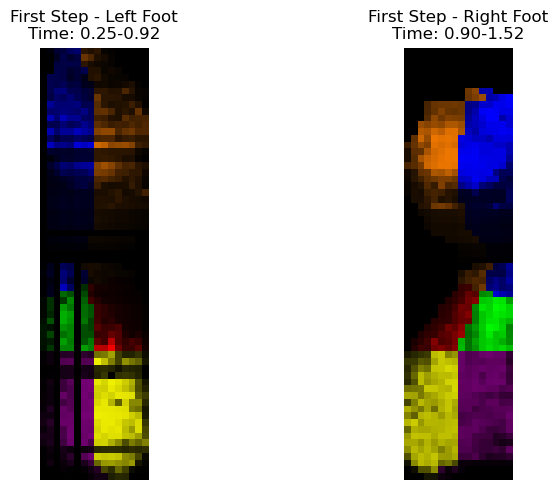

In [ ]:
def flip_top_half(image):
    """
    Flip the top half of the given image vertically.
    """
    h = image.shape[0]
    half = h // 2
    # Flip only the top half (rows 0 to half)
    top_half_flipped = np.flipud(image[:half, :])
    # Keep the bottom half unchanged
    bottom_half = image[half:, :]
    # Reassemble the image
    return np.vstack([top_half_flipped, bottom_half])

# Determine time ranges for the first step of each foot
first_step_l = gait_events['steps_l'][0]
first_step_r = gait_events['steps_r'][0]

left_start_idx = first_step_l['strike'][0]
left_end_idx   = first_step_l['off'][0] if first_step_l['off'] else first_step_l['strike'][1]
left_start_time = float(t_insole_l[left_start_idx][0])
left_end_time   = float(t_insole_l[left_end_idx][0])
left_time_range = (left_start_time, left_end_time)

right_start_idx = first_step_r['strike'][0]
right_end_idx   = first_step_r['off'][0] if first_step_r['off'] else first_step_r['strike'][1]
right_start_time = float(t_insole_r[right_start_idx][0])
right_end_time   = float(t_insole_r[right_end_idx][0])
right_time_range = (right_start_time, right_end_time)

# Build the color-coded images for the first step of each foot with new filepaths
foot_left_img = build_first_step_color_image(
    'data_by_section/021925/walk_11/six/forelat_left.csv',
    'data_by_section/021925/walk_11/six/foremed_left.csv',
    'data_by_section/021925/walk_11/six/midlat_left.csv',
    'data_by_section/021925/walk_11/six/midmed_left.csv',
    'data_by_section/021925/walk_11/six/hindlat_left.csv',
    'data_by_section/021925/walk_11/six/hindmed_left.csv',
    region_colors,
    left_time_range,
    is_right_foot=False
)

foot_right_img = build_first_step_color_image(
    'data_by_section/021925/walk_11/six/forelat_right.csv',
    'data_by_section/021925/walk_11/six/foremed_right.csv',
    'data_by_section/021925/walk_11/six/midlat_right.csv',
    'data_by_section/021925/walk_11/six/midmed_right.csv',
    'data_by_section/021925/walk_11/six/hindlat_right.csv',
    'data_by_section/021925/walk_11/six/hindmed_right.csv',
    region_colors,
    right_time_range,
    is_right_foot=True
)

# Apply the top-half vertical flip to both images
foot_left_img_flipped = flip_top_half(foot_left_img)
foot_right_img_flipped = flip_top_half(foot_right_img)

# --- Plot the color-coded foot images side by side ---
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(foot_left_img_flipped, origin='upper')
plt.title(f"First Step - Left Foot\nTime: {left_time_range[0]:.2f}-{left_time_range[1]:.2f}")
plt.axis('off')

plt.subplot(1, 2, 2)
# Apply horizontal flip for right foot after top half flip
plt.imshow(np.fliplr(foot_right_img_flipped), origin='upper')
plt.title(f"First Step - Right Foot\nTime: {right_time_range[0]:.2f}-{right_time_range[1]:.2f}")
plt.axis('off')

plt.tight_layout()
plt.show()